# Concept Drift Primer

Predictive models are fundamentally based on finding a mapping between the input data and the target variable. Typically, our goal is to learn a model from historical data with the intention of applying the updated model to new unseen data to derive insights. However, models that assume this underlying mapping to be static over time becomes susceptible to predictive performance degradation. 

Concept drift refers to the phenomenon of dynamically evolving latent relationships within the data, causing a shift in the relationship between the $x$ independent variables and the $y$ target variable. This manifests as a change in the joint distribution of features and the label $P(x, y)$ between the source distribution and the live distribution. 

$$ P(x_s, y_s) \neq P(x_l, y_l) $$

where $s$ is the source distribution and $l$ the live distribution. 

From a Bayesian perspective, this concept drift can be attributed to 2 fundamental forms of changes:

1. change in $p(y | x)$ i.e posterior probability distribution changes without change in $p(x)$. Also referred as the "real" concept drift.

$$ P(y_l|x_l) \neq P(y_l|x_l) \quad \& \quad P(x_s) = P(x_l) $$

2. change in the marginal probability distribution $P(x_s) \neq P(x_l)$, which doesn't affect the decision boundary and it referred as "virtual" drift or covariate shift.

> *Note:* Exisiting studies tend to prioritise detecting posterior distribution change as this typically forms the optimal decision rule - the model prediction is a function of the posterior distribution $p(y | x)$. For classification, the prediction is the mode of $p(y | x)$ aka MAP estimate. 

>**Also one key criteria for monitoring "real" concept drift (i.e. $p(y | x)$) is availability of actual labels to compare with the model's predicted labels**

### [Different types of concept drift](https://arxiv.org/pdf/2004.05785.pdf)

- **Abrupt**: Concept changes within a short time. The transition from current concept to the new one is abrupt. Also known as concept shift. It’s easiest to detect this kind of concept drift
- **Gradual**: A new concept replaces the old concept gradually over time. There are intermediate concepts which can be instances of old concept or the new concept being faced.
- **Incremental**: An existing concept incrementally changes to a new concept. There are intermediate concepts  are defined by the old and the new concept but does not belong to either
- **Reoccuring**: An old concept will re occur after some time. The transitions could any combination of the aforementioned 3 types of combinations

<img src="https://csdl-images.computer.org/trans/tk/2019/12/figures/lu4-2876857.gif" alt="biasv" width="500"/>

### [DDM: Drift Detection Method](https://www.cs.upc.edu/~abifet/EDDM.pdf)

This is one of the earliest and simplest. It’s based on prediction error rate. 

***Note:*** This **error rate** can be **metric that measures the distance between the true/actual target/label $y_{actual}$ distribution  vs the model's predicted target/label $y_{pred}$ distribution.** (eg: we can substitute the error rate to be the **Population Stability Index**)

For each point $i$ in the sequence that is being sampled, the error rate is the probability of missclassiying $p_i$ with standard deviation given by $s_i$.

If the error of the algorithm has a significant increase, the class distribution is changing and thus the actual decision model is likely to be inappropriate. 

1) Begin by evaluating $p_i$ and $s_i$.

2) Determine & store the values of $p_i$ and $s_i$ when $p_i + s_i$ reaches its minimum value during the process (obtaining $p_{min}$ and $s_{min}$).

3) Check for the following condition triggers:
- **Warning level:** $p_i + s_i \geq p_{min} + 2s_{min} $ 
    - *beyond this level examples must be stored in anticipation of possible change in concept.*
    
- **Drift level:** $p_i + s_i \geq p_{min} + 3s_{min} $ - beyond this level concept drift is supposed to be true. 
    - *Therefore, the model induced by the learning method is no longer applicable and should be reset. Learn a new model using the examples stored since the warning level triggered. The values for $p_{min}$ and $s_{min}$ must be reset too.*


## EDDM

### [ Early Drift Detection Method](https://www.cs.upc.edu/~abifet/EDDM.pdf)

Similar to DDM however, it is considered to be better for gradual drift. 

The basic idea is to consider the distance between two errors classification instead of considering only the number of errors. While the learning method is learning, it will improve the predictions and the distance between two errors will increase.

1) Calculate the **average distance between two errors** ($p′_i$) and its **standard deviation** ($s′_i$).

2) Determine & store values of $p′_i$ and $s′_i$, when $p′_i + 2s′_i$ reaches its maximum value (obtaining $p′_{max}$ and $s′_{max}$).

3) Calculate the warning EEDM ratio $\frac{p′_i + 2s′_i}{p′_{max} + 2s′_{max}}$.

4) When this drops below a threshold of 0.95 - drift is considered to have occurred. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('E_DDM.csv')

In [3]:
data.head()

,Dates,MCE
0,02/01/2019,0.7074
1,02/02/2019,0.6949
2,02/03/2019,0.7788
3,02/04/2019,0.6792
4,02/05/2019,0.6982


## EDDM function

In [4]:
def find_eddm_max_index(df, metric, max_metric):
    return df[df[metric] == max_metric].index[0]

def create_eddm_df(error):
    df = pd.DataFrame({'Error':error})
    df['DiffError'] = df['Error'].diff()
    df['pi'] = df['DiffError'].rolling(window=len(error), min_periods=1).mean()
    df['si'] = df['DiffError'].rolling(window=len(error), min_periods=1).std(ddof=0)
    df['pi+2si'] = df['pi']+(2*df['si'])
    df['max_pi+2si'] = df['pi+2si'].rolling(window=len(error), min_periods=1).max()
    
    df = df.fillna(0)

    df['index_max_pi+2i'] = df['max_pi+2si'].map(lambda x:find_eddm_max_index(df, 'pi+2si', x))
#     df['pi_max'] = np.array(df['pi'].iloc[df['index_max_pi+2i']])
#     df['si_max']=np.array(df['si'].iloc[df['index_max_pi+2i']])
    df['pi_max'] = df['pi'][df['index_max_pi+2i']].to_numpy()
    df['si_max'] = df['si'][df['index_max_pi+2i']].to_numpy()
    
    return df

def check_eddm_threshold(eddm_signal):
    eddm_warning_thresh = 0.95
    eddm_drift_thresh = 0.90
    
    eddm_warning_boolean = eddm_signal < eddm_warning_thresh
    eddm_drift_boolean = eddm_signal < eddm_drift_thresh
    
    return eddm_warning_boolean, eddm_drift_boolean

#main function
def eddm_warning(error, time):
    df = create_eddm_df(error)
    df['Dates'] = time
    df['EDDM_signal'] = df['pi+2si']/(df['pi_max']+(2*df['si_max']))
    eddm_warning_thresh, eddm_drift_thresh = check_eddm_threshold(df['EDDM_signal'])
    df['EDDM_Warn'] = eddm_warning_thresh
    df['EDDM_Drift'] = eddm_drift_thresh

    return df

def plot_eddm(error, time):
    eddm_data = eddm_warning(error, time)
    
    plt.figure(figsize=(15,6))
    plt.plot(eddm_data['Dates'], eddm_data['Error'], label='Error rate')
    plt.scatter(eddm_data['Dates'][eddm_data['EDDM_Drift']], eddm_data['Error'][eddm_data['EDDM_Drift']], color='red', marker='x', label = 'drift level')
    plt.xticks(rotation=90)
    plt.legend(fontsize=15)
    plt.show()
    

In [5]:
error = data['MCE'].iloc[:60]
time = data['Dates'].iloc[:60]
eddm_warning(error, time).head(15)

,Error,DiffError,pi,si,pi+2si,max_pi+2si,index_max_pi+2i,pi_max,si_max,Dates,EDDM_signal,EDDM_Warn,EDDM_Drift
0,0.7074,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,02/01/2019,NaN,False,False
1,0.6949,-0.0125,-0.012500,0.000000,-0.012500,-0.012500,1,-0.012500,0.000000,02/02/2019,1.000000,False,False
2,0.7788,0.0839,0.035700,0.048200,0.132100,0.132100,2,0.035700,0.048200,02/03/2019,1.000000,False,False
3,0.6792,-0.0996,-0.009400,0.074946,0.140491,0.140491,3,-0.009400,0.074946,02/04/2019,1.000000,False,False
4,0.6982,0.0190,-0.002300,0.066060,0.129819,0.140491,3,-0.009400,0.074946,02/05/2019,0.924037,True,False
5,0.7944,0.0962,0.017400,0.071017,0.159435,0.159435,5,0.017400,0.071017,02/06/2019,1.000000,False,False
6,0.6881,-0.1063,-0.003217,0.079549,0.155882,0.159435,5,0.017400,0.071017,02/07/2019,0.977719,False,False
7,0.6860,-0.0021,-0.003057,0.073649,0.144242,0.159435,5,0.017400,0.071017,02/08/2019,0.904709,True,False
8,0.6371,-0.0489,-0.008788,0.070541,0.132295,0.159435,5,0.017400,0.071017,02/09/2019,0.829777,True,True
9,0.6334,-0.0037,-0.008222,0.066526,0.124830,0.159435,5,0.017400,0.071017,02/10/2019,0.782956,True,True


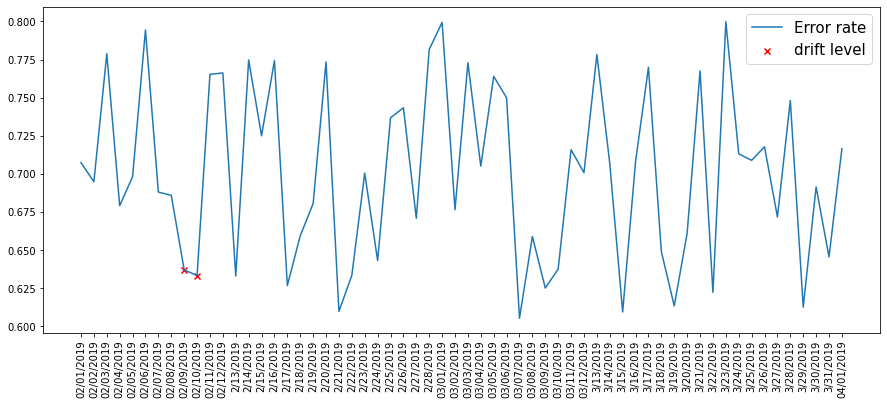

In [6]:
plot_eddm(error, time)

## Resetting after drift is detected

In [7]:
data = pd.read_csv('E_DDM.csv')
eddm_data = data[:60]
error = eddm_data['MCE']
time = eddm_data['Dates']
df = eddm_warning(error, time)    

drift_time = []
drift_error = []

for i in range(0, len(df)):
    if (df['EDDM_Drift'][i] == True):
        error = eddm_data['MCE'].iloc[i:,]
        time = eddm_data['Dates'].iloc[i:,]
        df = eddm_warning(error, time) 
        
        drift_time.append(eddm_data['Dates'].iloc[i])
        drift_error.append(eddm_data['MCE'].iloc[i])

        print("{}. Drift time: {}".format(i, eddm_data['Dates'].iloc[i]))
        print("{}. Drift error: {}".format(i, eddm_data['MCE'].iloc[i]))
    

8. Drift time: 02/09/2019
8. Drift error: 0.6371
11. Drift time: 02/12/2019
11. Drift error: 0.7662
14. Drift time: 2/15/2019
14. Drift error: 0.725
37. Drift time: 03/10/2019
37. Drift error: 0.6376
54. Drift time: 3/27/2019
54. Drift error: 0.6718
58. Drift time: 3/31/2019
58. Drift error: 0.6456


Works!! Same as manual check!

<img src="images/manual_check.png" alt="biasv" width=600 />



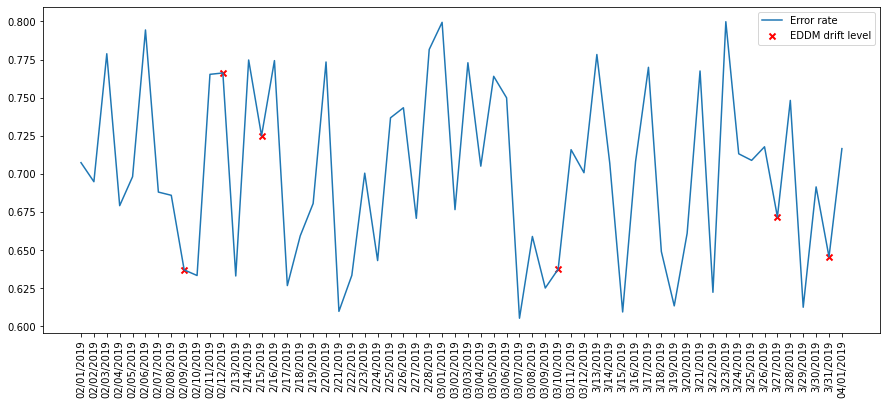

In [8]:
plt.figure(figsize=(15,6))

plt.plot(eddm_data['Dates'].iloc[:60], eddm_data['MCE'].iloc[:60], label='Error rate')
plt.scatter(drift_time, drift_error, color='red',  marker='x', linewidth=2, label = 'EDDM drift level')
plt.xticks(rotation=90)
plt.legend(fontsize=10)